# Analysing output of t2p
This is a short demo explaining how to explore the output of track2p and use the matched neurons/traces for custom downstream analysis.

The example here is for a 1 plane recording with simultaneous videography (given dataset is jm032).

In [1]:
# imports
import os
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore


## Step by step guide (more detailed explanations below):

Each point from this list matches one section of this notebook

1) Load the output of track2p
2) Find cells that are present in all recordings ('matched cells')
3) Load the data from one example dataset and visualise it
4) Load the activity of the matched cells
5) Visualise the activity of matched cells

## 1) Load the output of track2p
We will load the `.npy` files: `t2p_output_path/track2p/plane#_match_mat.npy` and `t2p_output_path/track2p/track_ops.npy`. These are the matrix of cell matches for all days and the settings respectively. For more info see the repo readme and documentation.

Note: In this demo a single-plane recording is used, but it can be modified easily for multiplane compatility (just repeat the same procedure while looping through planes)

In [2]:
# this is the directory that contains a /track2p folder that is output by running the track2p algorithm
t2p_save_path = 'data/jm/jm038/' # (change this based on your data)
plane = 'plane0' # which plane to process (the example dataset is single-plane)

In [3]:
# np.load() the match matrix (plane0_match_mat.npy)
t2p_match_mat = np.load(os.path.join(t2p_save_path, 'track2p', f'{plane}_match_mat.npy'), allow_pickle=True)

# np.load() settings (this contains suite2p paths etc.) (track_ops.npy)
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary

### 2) Find cells that are present in all recordings ('matched cells')



Now from this matrix get the matches that are present on all days:

- A matrix (`plane#_match_mat.npy`) containing the indices of matched neurons across the session for a given plane (`#` is the index of the plane). Since matching is done from first day to last, some neurons will not be sucessfully tracked after one or a few days. In this case the matrix contains `None` values. To get neurons tracked across all days only take the rows of the matrices containing no `None` values. 

Note: of course we can use cells that are not present on all days, but for now this is the intended use case for downstream analysis.

In [4]:
# get the rows that do not contain any Nones (if track2p doesnt find a match for a cell across two consecutive days it will append a None) -> cells with no Nones are cells matched across all days
t2p_match_mat_allday = t2p_match_mat[~np.any(t2p_match_mat==None, axis=1), :]

print(f'Shape of match matrix for cells present on all days: {t2p_match_mat_allday.shape} (cells, days)')

Shape of match matrix for cells present on all days: (803, 7) (cells, days)


### 3) Load the data from one example dataset and visualise it

Note: The track_ops.npy ('settings file') contains all the paths to suite2p folders used when running track2p (see cell below)

In [5]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    print(ds_path)

Datasets used for t2p:

/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-04-30_a
/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-01_a
/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-02_a
/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-03_a
/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-04_a
/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-05_a
/Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-06_a


Now just to test if the paths work we can try to look at data of one of the recordings (in the case below we use the last one). For this part it is important to know a bit about how the suite2p structures the outputs: https://suite2p.readthedocs.io/en/latest/outputs.html (the important things will be the `ops.npy`, `stat.npy`, `iscell.npy` and the `F.npy`). There are also separate tutorials and demos for this so we won't go into so much detail.

In [6]:
# lets take the last dataset
last_ds_path = track_ops.all_ds_path[-1]
print(f'We will look at the dataset saved at: {last_ds_path}')

We will look at the dataset saved at: /Users/jure/Documents/cossart_lab/data/jm/jm038/2023-05-06_a


In [7]:
# load the three files
last_ops = np.load(os.path.join(last_ds_path, 'suite2p', plane, 'ops.npy'), allow_pickle=True).item()
last_f = np.load(os.path.join(last_ds_path, 'suite2p', plane, 'F.npy'), allow_pickle=True)
iscell = np.load(os.path.join(last_ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)

In [8]:
# we filter the traces based on suite2p's iscell probability (note: it is crucial to use the same probability as in the track2p settings to keep the correct indexing of matches)
iscell_thr = track_ops.iscell_thr

print(f'The iscell threshold used when running track2p was: {iscell_thr}')

if track_ops.iscell_thr==None:
    last_f_iscell = last_f[iscell[:, 0] == 1, :]

else:
    last_f_iscell = last_f[iscell[:, 1] > iscell_thr, :]

The iscell threshold used when running track2p was: 0.5


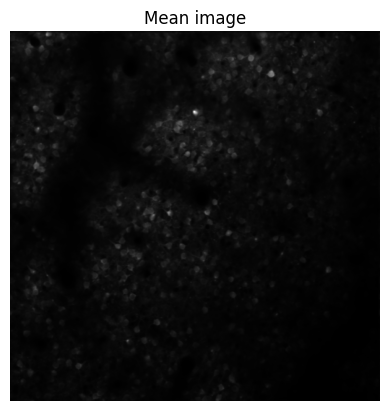

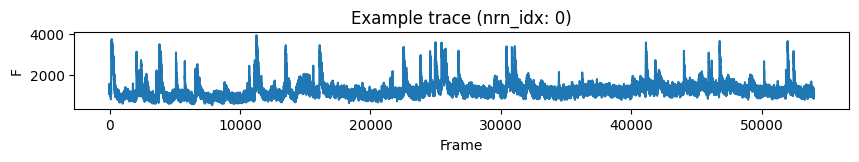

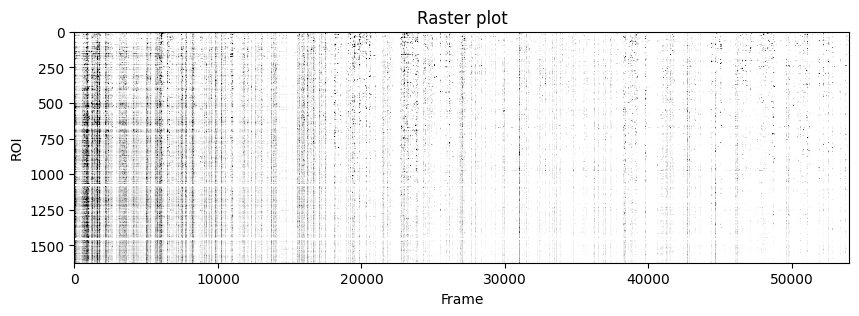

In [9]:
# now first plot the mean image of the movie (it is saved in ops.npy, for more info see the suite2p outputs documentation)
plt.imshow(last_ops['meanImg'], cmap='gray')
plt.axis('off')
plt.title('Mean image')
plt.show()

plt.figure(figsize=(10, 1))
nonmatch_nrn_idx = 0
plt.plot(last_f[nonmatch_nrn_idx, :])
plt.xlabel('Frame')
plt.ylabel('F')
plt.title(f'Example trace (nrn_idx: {nonmatch_nrn_idx})')
plt.show()

plt.figure(figsize=(10, 3))
plt.imshow(zscore(last_f_iscell, axis=1), aspect='auto', cmap='Greys', vmin=0, vmax=1.96)
plt.xlabel('Frame')
plt.ylabel('ROI')
plt.title('Raster plot')
plt.show()


## 4) Load the activity of the matched cells

Now that we know how to look at data in one recording we will use the output from track2p to look at activity of the same cells across all datasets.

To do this we need to loop through all datasets and:
- load the files described above
- filter `stat.npy` and `fluo.npy` by the track2p iscell threshold (classical suite2p)
- filter `stat.npy` and `fluo.npy` by the appropriate indices from the matrix of neurons matched on all days (additional filtering step after track2p)

This will produce a nice data structure where the indices of cells are matched within the stat and fluo objects. Sorting the object in this way allows for very straightforward extraction of matched data (see cells below)

In [10]:
iscell_thr = track_ops.iscell_thr # use the same threshold as when running the algo (to be consistent with indexing)

all_stat_t2p = []
all_f_t2p = []
all_ops = [] # ops dont change

for (i, ds_path) in enumerate(track_ops.all_ds_path):
    ops = np.load(os.path.join(ds_path, 'suite2p', plane, 'ops.npy'), allow_pickle=True).item()
    stat = np.load(os.path.join(ds_path, 'suite2p', plane, 'stat.npy'), allow_pickle=True)
    f = np.load(os.path.join(ds_path, 'suite2p', plane, 'F.npy'), allow_pickle=True)
    iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
    
    
    if track_ops.iscell_thr==None:
        stat_iscell = stat[iscell[:, 0] == 1]
        f_iscell = f[iscell[:, 0] == 1, :]

    else:
        stat_iscell = stat[iscell[:, 1] > iscell_thr]
        f_iscell = f[iscell[:, 1] > iscell_thr, :]
    
    
    stat_t2p = stat_iscell[t2p_match_mat_allday[:,i].astype(int)]
    f_t2p = f_iscell[t2p_match_mat_allday[:,i].astype(int), :]

    all_stat_t2p.append(stat_t2p)
    all_f_t2p.append(f_t2p)
    all_ops.append(ops)



### 5) Visualise the ROIs and the activity of (a) matched cell(s)


This example shows how to extract the information of a ROI from all_stat. We first index by the day to get stat_t2p from all_stat2p (this is the sorted stat object for that day). We can then get the roi information by indexing stat_t2p by the index of the cell match (because of resorting we use the same index across days).

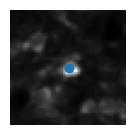

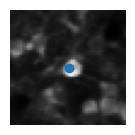

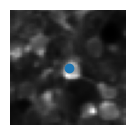

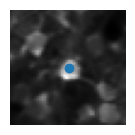

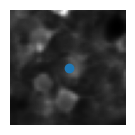

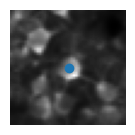

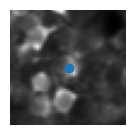

In [11]:
wind = 24
nrn_idx = 0

for i in range(len(track_ops.all_ds_path)):
    mean_img = all_ops[i]['meanImg']
    stat_t2p = all_stat_t2p[i]
    median_coord = stat_t2p[nrn_idx]['med']

    plt.figure(figsize=(1.5,1.5))
    plt.imshow(mean_img[int(median_coord[0])-wind:int(median_coord[0])+wind, int(median_coord[1])-wind:int(median_coord[1])+wind], cmap='gray') # plot a short window around the ROI centroid
    plt.scatter(wind, wind)
    plt.axis('off')
    plt.show()

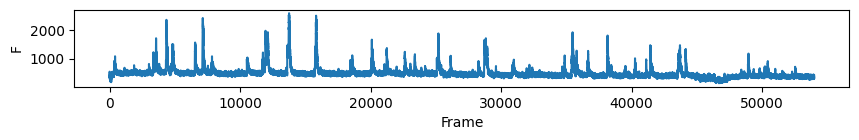

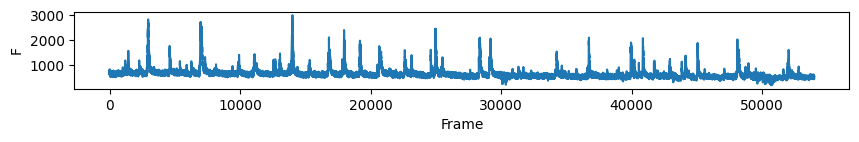

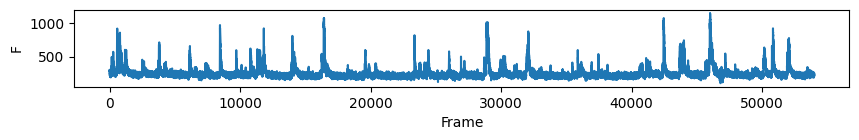

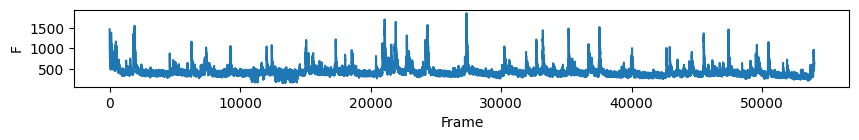

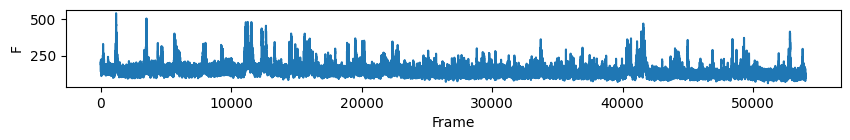

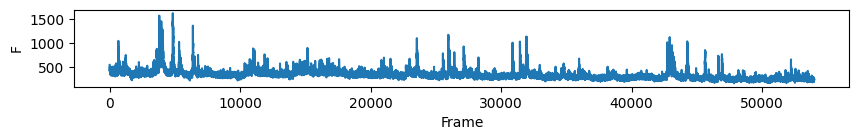

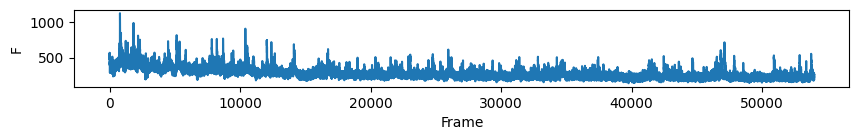

In [12]:
# first plot the trace of cell c for all days
nrn_idx = 0 # the activity of the ROI visualised above on all days

for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(10, 1)) # make a wide figure
    plt.plot(all_f_t2p[i][nrn_idx, :])
    plt.xlabel('Frame')
    plt.ylabel('F')
    plt.show()


Now to visualise the rasters its a simple exercise, since they are already sorted in a way that the rows represent the same cell across days we don't need to do anything other than simply looping through all_f_t2p and plotting each element as we did before.

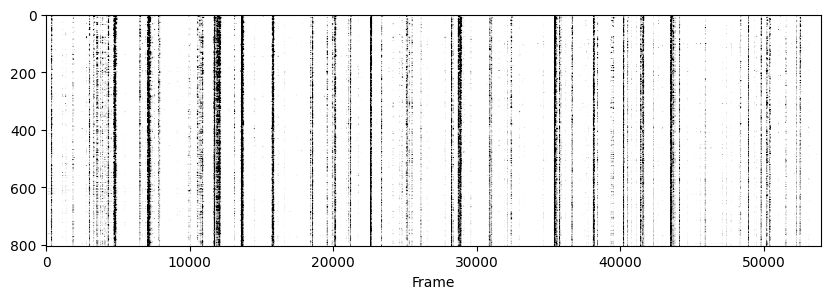

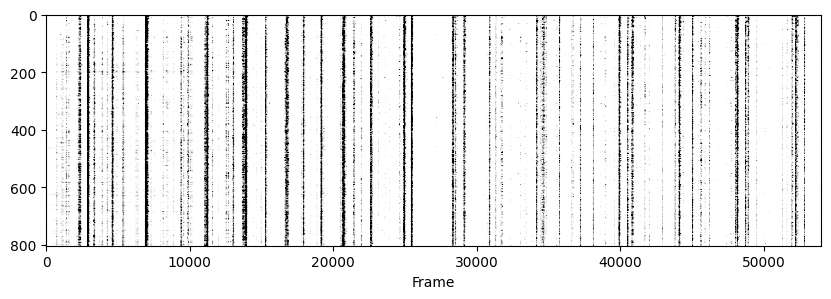

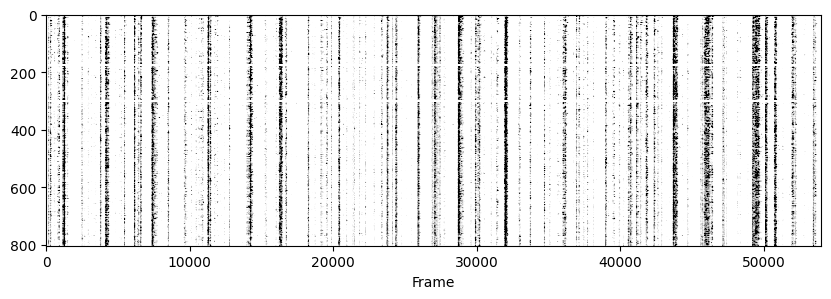

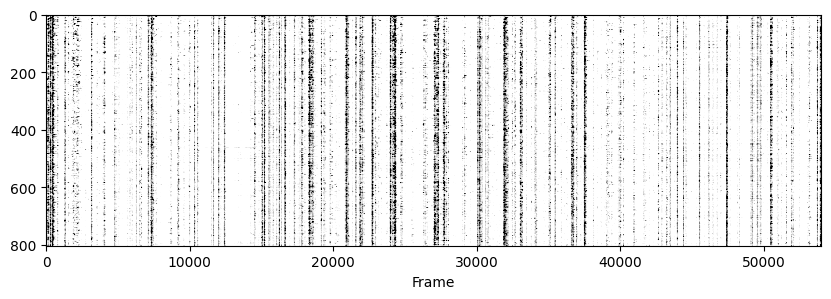

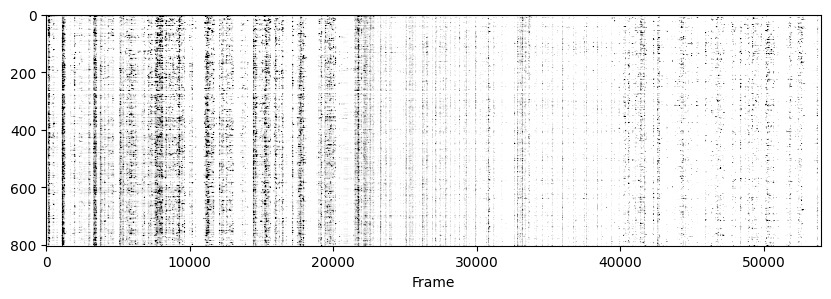

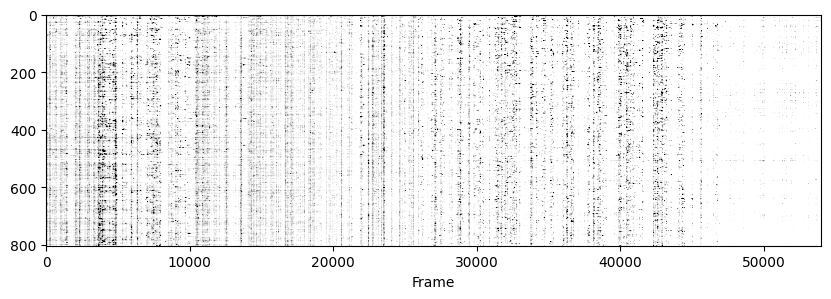

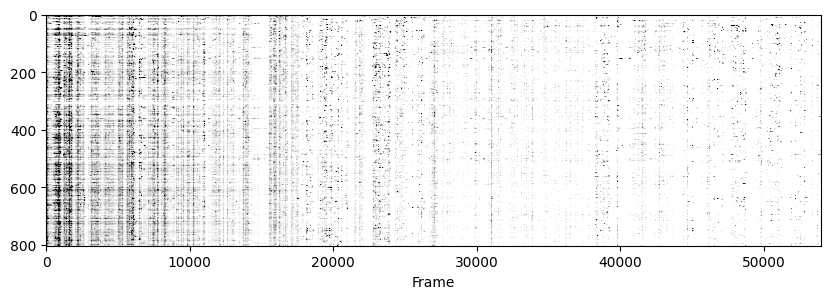

In [13]:
for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(10, 3)) # make a wide figure
    f_plot = zscore(all_f_t2p[i], axis=1)
    plt.imshow(f_plot, aspect='auto', cmap='Greys', vmin=0, vmax=1.96)
    plt.xlabel('Frame') 

### The End!

Congrats! Hopefully this notebook was a clear and useful way of showing how to interact with the track2p outputs.

From here on custom analysis pipelines can very easily be applied (for example looking at stability of assemblies, representational drift etc etc). 

The most straightforward way of doing this is to just run an already implemented pipeline on the data loaded as shown here. Alternatively the loaded match indices can be used to look at already-processed data as a way of post-hoc matching.

Thanks and have fun with analysis :)